# RL coursework, part III (25 pts total)
---

**Name:** Your Name

**SN:** Your Student Number

---

**Due date:** *April 11th, 2024*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part3.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

# The Assignment

### Objectives

You will be guided through the implementation of a full deep reinforcement learning agent.

## Setup

Run all the cells in this section, but do not modify them.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)

## Helpers

# A) Actor-critics

You are going to implement an Actor-critic agent that updates a policy parametrised as a deep neural network.

The agent learns online from a single stream of experience, updating the parametes of its policy after each transition in the environment.

### Install packages

In [2]:
!pip install -U jaxlib==0.4.23
!git clone https://github.com/deepmind/bsuite.git
!pip install bsuite/

  Obtaining dependency information for jaxlib==0.4.23 from https://files.pythonhosted.org/packages/84/d5/404277971fb9d3be7f303b7301faac98b3ff27626c10b88c5d7727c3ef04/jaxlib-0.4.23-cp39-cp39-win_amd64.whl.metadata
  Using cached jaxlib-0.4.23-cp39-cp39-win_amd64.whl.metadata (2.1 kB)
Using cached jaxlib-0.4.23-cp39-cp39-win_amd64.whl (45.9 MB)
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.26
    Uninstalling jaxlib-0.4.26:
      Successfully uninstalled jaxlib-0.4.26


fatal: destination path 'bsuite' already exists and is not an empty directory.


Processing c:\users\alina\repos\ucl\rl\bsuite
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for bsuite: filename=bsuite-0.3.5-py3-none-any.whl size=251159 sha256=6d86e14734acdc4364c80e21ffdfdb6e85712eff26953829829393a532765103
  Stored in directory: C:\Users\alina\AppData\Local\Temp\pip-ephem-wheel-cache-c3bae88s\wheels\a7\96\64\2a827647171c1bab498e721d88d226e4416caa9f18bf75282b
Successfully built bsuite
  Attempting uninstall: bsuite
    Found existing installation: bsuite 0.3.5
    Uninstalling bsuite-0.3.5:
      Successfully uninstalled bsuite-0.3.5


### Imports

In [3]:
pip install --upgrade jax jaxlib

  Obtaining dependency information for jaxlib from https://files.pythonhosted.org/packages/88/89/1c6f95fdd98babbc9860ab5dad9a6758ce7e5665d3f18193d96da06053c2/jaxlib-0.4.26-cp39-cp39-win_amd64.whl.metadata
  Using cached jaxlib-0.4.26-cp39-cp39-win_amd64.whl.metadata (1.8 kB)
Using cached jaxlib-0.4.26-cp39-cp39-win_amd64.whl (46.4 MB)
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.23
    Uninstalling jaxlib-0.4.23:
      Successfully uninstalled jaxlib-0.4.23
Note: you may need to restart the kernel to use updated packages.


In [4]:
from bsuite.environments import catch

import jax
import jax.numpy as jnp

### Plotting

In [5]:
def plot_learning_curve(list_of_episode_returns):
  """Plot the learning curve."""
  plt.figure(figsize=(7, 5))

  def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

  smoothed_returns = moving_average(list_of_episode_returns, 30)
  plt.plot(smoothed_returns)

  plt.xlabel('Average episode returns')
  plt.xlabel('Number of episodes')

  ax = plt.gca()
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(True)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('left')

### Neural networks

You will use JAX to define a network parametrising:

* The values of each state $v(s)$.
* The action preferences in each state $\{p_i(s)\}_{i\in\{1, ..., |A|\}}$ (you can think of and implement the preferences $\mathbf{p}(s)$ as a vector output with $|A|$ elements).

There are many neural network libraries available that can be used to create networks in jax.  But here we will keep things relatively simple and just define our own network.

Specifically, we will define a `network` function returns a **scalar** value `v` and a **vector** of preferences `p`, which will define the policy of the agent.  This function will take as its inputs a dictionary `params` of parameters that we will update, which will contain all the parameters of the network.

A lot of the boilerplate code has been written for you.  You will have to implement some functions as indicated in the questions below.

### Q1 [4 marks]

Create the parameters and define the forward pass of the neural network. The `network` function must look as follows when we call it:
`v, p = network(params, observation)`

The network should be implemented as follows:
* The inputs are a dictionary of parameters `params`, and a tensor (a `jnp.array`) called `observation`.
* We reshape the observation into a flat vector `flat_observation`.
* We compute a hidden representation
`h = relu(flat_observation.dot(w) + b)`, where the weights and biases are given in the input dictionary as `w = params['w']` and `v = params['b']` (and analogously for all other parameters), and where `relu(x)` is a 'rectifier linear unit', which computes $\max(x, 0)$ elementwise (you can use `jax.nn.relu(x)` to implement this, if you want).
* We compute a vector of action preferences as a linear function of `h`, such that `p = h.dot(w_p) + b_p`.
* Similarly, we compute a scalar state value `v` as a linear function of `h`.
* Finally, we return the scalar value and vector preferences as a tuple.

Further, make sure that:
* The hidden representation should be a vector of 50 elements.
* The action preferences should be a vector of 3 elements (one per each available action).
* The value should be a scalar (not a vector with one element).
* All parameters should be initialised randomly as follows:
```
rng_key, param_key = jax.random.split(rng_key)
parameter = jax.random.truncated_normal(param_key, -1, 1, shape)
```
where `shape` is the relevant shape for this `parameter` (e.g., `parameter` is `w` or `b`, etc.).  The first line is important: it 'splits' the random key into a temporary random key `param_key` that should **only** be used for this parameter, and a new `rng_key` that can be split again later for the next parameters, etc.


In [6]:
!pip install dm-haiku
import haiku as hk

In [7]:
hidden_dim = 50
output_dim_p = 3
output_dim_v = 1
def create_parameters(rng_key, observation):
    # Returns a dictionary with the desired parameters for the network
    input_dim = jnp.size(observation)
    params = {}
    
    #first layer
    
    #w
    rng_key, param_key = jax.random.split(rng_key)
    params['w'] = jax.random.truncated_normal(
        param_key, -1, 1, (input_dim, hidden_dim)
    )
    
    #b
    rng_key, param_key = jax.random.split(rng_key)
    params['b'] = jax.random.truncated_normal(
        param_key, -1, 1, (hidden_dim,)
    )

    #second layer(hidden)
    
    #w_p
    rng_key, param_key = jax.random.split(rng_key)
    params['w_p'] = jax.random.truncated_normal(
        param_key, -1, 1, (hidden_dim, output_dim_p)
    )
    
    #b_p
    rng_key, param_key = jax.random.split(rng_key)
    params['b_p'] = jax.random.truncated_normal(
        param_key, -1, 1,(output_dim_p,))
    
    #w_v
    rng_key, param_key = jax.random.split(rng_key)
    #output layer
    params['w_v'] = jax.random.truncated_normal(
        param_key, -1, 1, (hidden_dim, output_dim_v)
    )
    
    #b_v
    rng_key, param_key = jax.random.split(rng_key)
    #scalar
    params['b_v'] = jax.random.truncated_normal(
        param_key, -1, 1,(output_dim_v,))

    return params

In [8]:
def network(params, observation):
  # Implement forward pass here
  flat_observation = observation.flatten()
  h = flat_observation.dot(params['w']) + params['b']
  h = jax.nn.relu(h)
  assert h.shape == (50,)
  p = h.dot(params['w_p'])+ params['b_p']
  assert p.shape == (3,)
  v = h.dot(params['w_v']) + params['b_v']
  #v must be a s calar
  v = v[0]
  assert jnp.ndim(v) == 0, "v must be a scalar"
  return v, p

### Choosing actions

A critical component of an actor-critic agent is a (stochastic) policy, mapping `observations` to `actions`.

In deep RL, this mapping is conventionally parametrised by a deep neural network.

Here we provide a softmax policy parametrised by the neural network above (i.e., using the `network` function). The function has signature `action = softmax_policy(parameters, key, obs)`, taking the current network parameters `parameters`, a JAX random `key` and the current `observation`.

### Softmax definition

In [9]:
#DO NOT MODIFY
# Functions to perform random sampling in JAX (e.g. those in `jax.random`) take
# a random key as input, and they are deterministic function of such a key. In
# general, in a JAX program you need to use the `jax.random.split` function to
# generate new random keys before every new sampling. The run loop that runs the
# experiment later on will split and provides the keys for the function defined
# here.

# Note that we 'jit' the function.  This means the function will be compiled,
# which will make it run faster. This does also suppress print statements, so if
# you are debugging and want to print please comment out the `@jax.jit` line,
# but don't forget to put it back before running the experiment below, and
# especially before submitting your assignment.

@jax.jit
def softmax_policy(parameters, key, obs):
  """Sample action from a softmax policy."""
  _, p = network(parameters, obs)
  return jax.random.categorical(key, p)

### Learning values and policies

An actor-critic agent requires to update the parameters of the network so as to simultaneously improve the value predictions and the policy.

In the next section you will define the gradient updates for each of these two components.

### Q3 [4 marks]

Implement a function to compute a stochastic estimate of the policy gradient from a 1 step transition in the environment.

* You will use $R_{t+1} + \gamma v(S_{t+1})$ as an estimate of $q_{\pi}(S_t, A_t)$
* You will use $v(S_{t})$ as a baseline to reduce the variance of the updates.

In the code we actually use names `obs_tm1`, `a_tm1` (where `tm1` stands for '$t$ minus one') for the observation and action at time $t-1$, and `r_t`, `discount_t`, `obs_t` for the reward, discount, and observation at time $t$. So the code is offset a single time step in terms of naming as compared to the typical mathematical formulations.  This is just a naming convention, and should not impact the algorithm.

The function below must therefore have signature `grads = policy_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)`.
* Where the inputs are:
  * `parameters`: the parameters of the network,
  * an observation `obs_tm1`
  * the action `a_tm1` selected after observing `obs_tm1`,
  * the resulting reward `r_t` and discount `discount_t` and observation `obs_t`, as obsesrved after taking action `a_tm1`.

This function should return a stochastic estimate of the policy gradient, where `grads` has the same structure as `parameters` and contains an estimate of the gradient of the expected episodic return wrt to each parameter.

The policy-gradient estimate should use bootstrapping, using the value estimates that can be gotten using the saame `parameters` as used for the policy.  So the output of this function can be used in a one-step actor-critic update.

### Jax hint:
Note that you can use `jax.grad(f)` to get the gradient of any (pure) jax function with a scalar output.  For instance, consider:

        def f(w, x, y):
          # w, x, and y are all vectors
          return jnp.sum(w*x + y)

        df = jax.grad(f)
    
then calling `df(w, x, y)` will give the gradient of the output of `f(w, x, y)` with respect to the first input argument --- here called `w`. You can use this new function `df` as just a normal function. For instance, it can be called from other functions, as usual.

Run the cell below to see a concrete example in action.  Note that `df(w, x, y)` in the example below evaluates to the same values as `x`.  This is correct, because the gradient of `f` with respect to `w` is indeed `x`.

In [10]:
def f(w, x, y):
  return jnp.sum(w*x + y)

df = jax.grad(f)

w = jnp.array([1., 2.])
x = jnp.array([3., 5.])
y = jnp.array([7., 11.])

print(f'f(w, x, y):  {f(w, x, y)}')
print(f'df(w, x, y): {df(w, x, y)}')

f(w, x, y):  31.0
df(w, x, y): [3. 5.]


### Jax hint:
You network will have a dictionary `params` as input.  Suppose you have a function that computes the output of a network, and then uses this to do some stuff, and you want the gradient of that new function.  That is, suppose your code looks something like this:

        # Define network
        def network(params, ...):
          ...

        # Define a new function
        def function(params, x, y, z, ...):
           ...
           output = network(params, x)
           ...
           return ...(some function of output)...        

Now,
```
grads = jax.grad(function)(params, x, y, z, ...)
```
will give the gradients of `function` with respect to the first input argument, `params`.  These gradients `grads` will have exactly the same shape as the input argment `params`.

But note that we cannot do things like `params + grads`, because `params` and `grads` are both dictionaries, not just `jnp.array`s.  Instead, we could explicitly traverse the dictionary.  But it is perhaps even easier to use in-built tree utils in Jax.  Specifically, the util `jax.tree_map(f, x, y)` applies function f to all the elements in `x` and `y`.

For instance, to add the gradients to the parameters, we can use:
```
def add_gradient_to_weight(w, g, learning_rate=0.1):
  return w + learning_rate * g
new_params = jax.tree_map(add_gradient_to_weight, params, grads)
```
The above snippet would apply the function `add_gradient_to_weight` to the elements in `params` and `grads`, here adding each element in `grads` to each corresponding element in `weights` (in this case using the default learning rate `learning_rate=0.1`, as specified in the function definition).


In [11]:
# `parameters`: the parameters of the network,
# an observation `obs_tm1`
# the action `a_tm1` selected after observing `obs_tm1`,
# the resulting reward `r_t` and discount `discount_t` and observation `obs_t`, as obsesrved after taking action `a_tm1`.
def loss_fun(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  v_tm1, p_tm1 = network(parameters, obs_tm1)
  v_t, p_t = network(parameters, obs_t)
  
  #advantage
  #estimate of q_pi(S_t, A_t) = r_t+1+ gamma* v(S_t+1). v(S_t) as a baseline
  delta_t = jax.lax.stop_gradient(r_t + discount_t*v_t - v_tm1)
  #log_prob_action = jnp.log(p_tm1[a_tm1])
  log_prob_action = jax.nn.log_softmax(p_tm1)[a_tm1]
  theta = delta_t * log_prob_action
  return theta.squeeze()
    
def policy_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  grad = jax.grad(loss_fun)
  gradients = grad(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)

  return gradients

### Q4 [4 marks]

Implement a function to compute a TD(0) update for the parameters of the value function.

It must have signature `td_update = value_update(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)`.
* Where the inputs are:
  * the current parameters `parameters` of the network,
  * an observation `obs_tm1`
  * the action `a_tm1` selected after observing `obs_tm1`,
  * the resulting reward `r_t` and environment discount `discount_t`
  * and the following observation `obs_t`
* Returns a stochastic TD(0) semi-gradient update: `td_update` has the same structure as `parameters`. This contains a stochastic estimate of the negative semi-gradient of the expected value prediction loss: a TD(0) update.

In [12]:
def value_loss(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    v_tm1, p_tm1 = network(parameters, obs_tm1)
    v_t, p_t = network(parameters, obs_t)
    
    #advantage
    #estimate of q_pi(S_t, A_t) = r_t+1+ gamma* v(S_t+1). v(S_t) as a baseline
    delta_t = jax.lax.stop_gradient(r_t + discount_t*v_t - v_tm1)
    return (delta_t*v_tm1).squeeze()
    
def value_update(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    grad = jax.grad(value_loss)
    gradients = grad(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)

    return gradients
  

### Updating shared parameters

The policy gradient identifies the direction of change in the parameters that most steeply improve the policy.
The value update identifies the direction of change in the parameters that improves the value predictions (according to TD).

However, the value and policy share some of the parameters of the network.  How do we combine the two gradient updates?

In this assignment, we simply sum the policy and value components.
The function that combines the two gradients is implemented for you in the cell below.  Note the use of `jax.tree_map` to facilitate adding the structured parameters.

In [13]:
@jax.jit
def compute_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  pgrads = policy_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  td_update = value_update(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  return jax.tree_map(lambda pg, td: pg + td, pgrads, td_update)

### Optimisation

In deep learning, gradient updates are typically rescaled and modifed to avoid taking too large a step on a single update (e.g., due to large variance), and to facilitate the optimisation process (it turns out raw stochatic gradients are often not the most effective for updating neural networks).

For instance given a candidate gradient update $\nabla$ we may update our parameters $\theta$ by;
$$\Delta \theta = \theta + \alpha * \nabla\,,$$
where $\alpha$ is a small number between 0 and 1 (e.g., $\alpha=0.01$ or $\alpha=0.001$), referred to as `step_size` or `learning_rate`

The gradients with respect to each weight of a neural network may however have very different magnitudes. This can make it hard to set a suitable learning rate $\alpha$.

In deep learning, and deep RL, we typically use adaptive learning rates, for instance by rescaling each component of the gradient using statistics tracking the typical size of the updates to that weight. Then the entire update is rescaled using a global `learning_rate` $\alpha$.


### Q5 [2 marks]

A popular approach to adaptive gradient rescaling was introduced by the `Adam` algorithm.
This algorithm implements the following procedure before applying each update:
* Increase an update counter $k \gets k+1$ (starting at k=0 before any updates),
* Update the first moment of each gradient component $\mu \gets (1 - \beta_1) g + \beta_1 \mu$ where $g$ is the latest stochastic gradient, where $\beta_1$ is a parameter for the moving average.
* Update the second moment of each gradient component $\nu_i = (1 - \beta_2) g_i ^ 2 + \beta_2 \nu_i $ where $g$ is the latest gradient update, where $\beta_2$ is a parameter for the moving average.
* Use the following update to update the weights:
$$\Delta w = \alpha \frac{\mu / (1 - \beta_1 ^ {k})}{\epsilon + \sqrt{\nu / (1 - \beta_1 ^ {k})}}$$
* $\alpha$ is a global `learning rate`
* $\beta_1$ and $\beta_2$ define a soft horizon for the per-weight statistics.
* $\epsilon$ makes the rescaling more robust to numerical issues.

(See [Kingma et al, 2014](https://arxiv.org/abs/1412.6980) for details, if you are interested.)

In the next cell define a pair of functions (`opt_init`, and `opt_update` --- in each case `opt` is short for 'optimiser'), where:

The `opt_init` function has signature `opt_state = opt_init(parameters)`.
* Takes the network parameters as inputs
* Initialises an `optimiser state` holding the per weight statistics.

The `opt_update` function has signature `updates, opt_state = opt_update(grads, opt_state)`.
* Takes a `gradient` and an `optimisers state`,
* and returns the transformed gradient and the updated `optimiser state`.

The optimiser state `opt_state` should contain:
* The first-order momentum $\mu$, as updated with a moving-average-parameter $\beta_1$ which we call `b1` in the code.
* The first-order momentum $\nu$, as updated with a moving-average-parameter $\beta_2$ which we call `b2` in the code.

We will ignore the initial correction Adam typically uses, and will instead use the simpler transformation:
$$\Delta w = \alpha \frac{\mu}{\epsilon + \sqrt{\nu}}$$

Set the algorithm's hyper-parameters to $\alpha=0.003$, $\beta_1=.9$ and $\beta_2=.999$, $\epsilon=10^{-4}$.  You are allowed to hard-code these in, or make them configurable (e.g., pass them as additional arguments to `opt_update`, which is better if you want to play around, of course).  Set the initial moving averages to zero for $\mu$ and one for $\nu$.  E.g.,

        mu = jax.tree_map(jnp.zeros_like, parameters)

In [14]:
def opt_init(parameters,k=0, b1=0.9, b2=0.999):
  mu = jax.tree_map(jnp.zeros_like, parameters)
  v = jax.tree_map(jnp.ones_like, parameters)
  opt_state = (mu, v, k, b1, b2)
  return opt_state

def opt_update(grads, opt_state, alpha = 0.003, epsilon = 1e-4 ):
  mus, vs, k, b1, b2 = opt_state
  k +=1
  mus_updated = jax.tree_map(lambda mu, grad: ((1 - b1) * grad) + (b1 * mu), mus, grads)
  vs_updated = jax.tree_map(lambda v, grad: ((1 - b2) * (grad**2)) + (b2 * v), vs, grads)
  updates = jax.tree_map(lambda v, mu: alpha*(mu/(epsilon+jnp.sqrt(v))), vs_updated, mus_updated)
  opt_state = (mus_updated, vs_updated, k, b1, b2)
  return updates, opt_state

### Run experiments

Run the cell below to show the performance of the resulting agent.

You may also use this section for debugging your implementations.

Note however, that most functions are `jitted` for performance,
* either using the `@jax.jit` decorator in the function definition
* or calling explicitly `fn = jax.jit(fn)`

When jitting, the code is compiled on the first time the function is executed
* and execution is much faster on subsequent calls.
* a notable side effect is that print statements in a jitted function will only execute on the first execution of the function.
* to drop into a debugger or print on each function execution you will have to disable the `@jax.jit` annotations and jax.jit calls.

C:\Users\alina\AppData\Local\Temp\ipykernel_27252\140107139.py:2: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  mu = jax.tree_map(jnp.zeros_like, parameters)
C:\Users\alina\AppData\Local\Temp\ipykernel_27252\140107139.py:3: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  v = jax.tree_map(jnp.ones_like, parameters)


Training agent for 2500 episodes...


C:\Users\alina\AppData\Local\Temp\ipykernel_27252\2734106140.py:5: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda pg, td: pg + td, pgrads, td_update)
C:\Users\alina\AppData\Local\Temp\ipykernel_27252\140107139.py:10: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  mus_updated = jax.tree_map(lambda mu, grad: ((1 - b1) * grad) + (b1 * mu), mus, grads)
C:\Users\alina\AppData\Local\Temp\ipykernel_27252\140107139.py:11: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  vs_updated = jax.tree_map(lambda v, grad: ((1 - b2) * (grad**2)) + (b2 * v), vs, grads)
C:\Users\alina\AppData\Local\Temp\ipykernel_27252\140107139.py:12: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) o

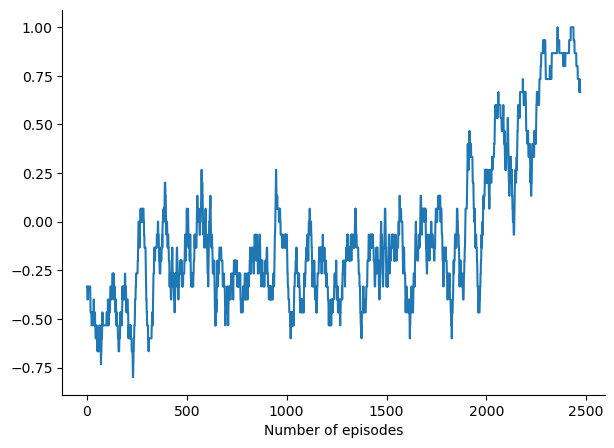

In [15]:
# DO NOT CHANGE THIS CELL

# Experiment configs.
train_episodes = 2500
discount_factor = .99

# Create environment.                                                                   
env = catch.Catch(seed=42)

# Build and initialize network.
rng = jax.random.PRNGKey(44)
rng, init_rng = jax.random.split(rng)
sample_input = env.observation_spec().generate_value()
parameters = create_parameters(init_rng, sample_input)

# Initialize optimizer state.
opt_state = opt_init(parameters)

# Apply updates
def apply_updates(params, updates):
  return jax.tree_map(lambda p, u: p + u, params, updates)

# Jit.
opt_update = jax.jit(opt_update)
apply_updates = jax.jit(apply_updates)

print(f"Training agent for {train_episodes} episodes...")
all_episode_returns = []

for _ in range(train_episodes):
  episode_return = 0.
  timestep = env.reset()
  obs_tm1 = timestep.observation

  # Sample initial action.
  rng, policy_rng = jax.random.split(rng)
  a_tm1 = softmax_policy(parameters, policy_rng, obs_tm1)

  while not timestep.last():
    # Step environment.
    new_timestep = env.step(int(a_tm1))

    # Sample action from agent policy.
    rng, policy_rng = jax.random.split(rng)
    a_t = softmax_policy(parameters, policy_rng, new_timestep.observation)

    # Update params.
    r_t = new_timestep.reward
    discount_t = discount_factor * new_timestep.discount
    dJ_dtheta = compute_gradient(
        parameters, obs_tm1, a_tm1, r_t, discount_t,
        new_timestep.observation)
    updates, opt_state = opt_update(dJ_dtheta, opt_state)
    parameters = apply_updates(parameters, updates)

    # Within episode book-keeping.
    episode_return += new_timestep.reward
    timestep = new_timestep
    obs_tm1 = new_timestep.observation
    a_tm1 = a_t

  # Experiment results tracking.
  all_episode_returns.append(episode_return)

# Plot learning curve.
plot_learning_curve(all_episode_returns)

# B) An alternative update

You are going to implement a different kind of agent.

Like an actor-critic, it learns online from a single stream of experience, updating the parametes after each transition in the environment.

### Neural networks


The agent will reuse the same neural network we defined for the actor-critic:
* the scalar output will be trained via TD to estimate state values
* the vector preferences `p` will be updated according to a different rule.

### Choosing actions

As in actor-critics, the (stochastic) mapping from `observations` to `actions` depends on the vector of preferences `p` from the network.

### Q6 [2 marks]

The new agent's policy will have the signature `action = epsilon_greedy_policy(parameters, key, observation)`,
* Take as inputs the current network parameters `parameters`, a JAX random `key` and the current `observation`
* Return with probability `0.9` the greedy `action` with respect to the preferences `p`, ties must be broken at random.
* Return an action uniformly at random with probability `0.1`

In [16]:
@jax.jit
def epsilon_greedy_policy(parameters, key, observation):
  """Sample action from an epsilon-greedy policy."""
  epsilon = 0.9
  rng_key, param_key = jax.random.split(key)
  
  # def get_max_indices(p, num_indices):
  #   max_value = jnp.max(p)
  #   max_mask = jnp.equal(p, max_value)
  #   max_indices = jnp.where(max_mask)[0]
  #   #this code is very specific to this particular case where valid indices are 0,1,&2, 3 will have to be replaces with different number of actions
  #   padded_indices = jnp.pad(max_indices, (0, num_indices - len(max_indices)), constant_values=3)
  #   return padded_indices

  def greedy(keys):
    rng_key, param_key = jax.random.split(keys)
    v, p = network(parameters, observation)
    #add random noise to max values of p to break the ties randomly
    noise = jax.random.uniform(rng_key, p.shape, minval=0, maxval=1e-5)
    action = jnp.argmax(p + noise)

    #max_actions_inds = get_max_indices(p, 3)
    
    # Check if max_actions_inds contains 3
    #contains_sentinel = jnp.any(max_actions_inds == 3)
    
    # If max_actions_inds contains 3, assign 0 probability to these indices and equal probability to others
    # if contains_sentinel:
    #     mask = jnp.not_equal(max_actions_inds, 3)
    #     equal_probs = jnp.ones(jnp.size(max_actions_inds))/ jnp.size(max_actions_inds)
    #     probs = jnp.where(mask, equal_probs, 0)
    # else:
    #     # If max_actions_inds doesn't contain 3, assign equal probabilities to all indices
    #     probs = jnp.ones(jnp.size(max_actions_inds)) / jnp.size(max_actions_inds)

    # break a tie
    #action = jax.random.choice(key=param_key, a =max_actions_inds, p=probs)

    return action

  def random(keys):
    rng_key, param_key = jax.random.split(keys)
    action = jax.random.choice(key=param_key, a = output_dim_p)
    return action

  action = jax.lax.cond(jax.random.uniform(param_key) < epsilon, greedy, random, rng_key)
    
  return action

### Q7 [3 marks]

The parameters $w_p$ of the preferences $p_{w_p}(s, a)$ will be update according to the following gradient-based update:

$$\Delta w_p = \alpha (R_{t+1} + \gamma v(S_{t+1}) - p(S_{t}, A_t)) \nabla p(S_t, A_t))$$

where `v` is the state value trained by TD as in the actor critic.

You musy implement this in the function `preference_gradient`, with the same signature as `policy_gradient`

In [17]:
def grad_loss(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    v_tm1, p_tm1 = network(parameters, obs_tm1)
    v_t, p_t = network(parameters, obs_t)
    delta = jax.lax.stop_gradient(r_t + discount_t * v_t - p_tm1[a_tm1])
    updates = delta*p_tm1[a_tm1]
    return updates

def preference_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    grad = jax.grad(grad_loss)
    gradients = grad(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)

    return gradients

### Updating shared parameters

Just like in the actor critic the overall update to the parameters is a combination of two quantities:
* the new update we defined for the vector of preferences
* the same TD update to the scalar output that we used in the actor critic

In [18]:
@jax.jit
def compute_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  pgrads = preference_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  vgrads = value_update(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  return jax.tree_map(lambda pg, td: pg + td, pgrads, vgrads)

### Optimisation

The gradient updates are rescaled using the same optimiser used for the actor-critic.

### Run experiments

Run the cell below to show the performance of the new agent.

C:\Users\alina\AppData\Local\Temp\ipykernel_27252\140107139.py:2: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  mu = jax.tree_map(jnp.zeros_like, parameters)
C:\Users\alina\AppData\Local\Temp\ipykernel_27252\140107139.py:3: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  v = jax.tree_map(jnp.ones_like, parameters)


Training agent for 2500 episodes...


C:\Users\alina\AppData\Local\Temp\ipykernel_27252\2854361996.py:5: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda pg, td: pg + td, pgrads, vgrads)
C:\Users\alina\AppData\Local\Temp\ipykernel_27252\1434496577.py:21: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda p, u: p + u, params, updates)


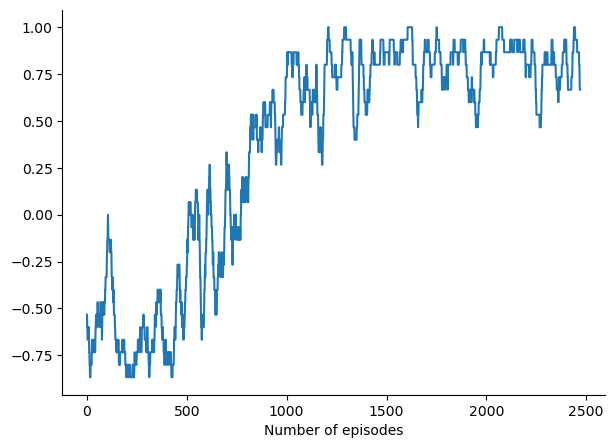

In [19]:
# DO NOT CHANGE THIS CELL

# Experiment configs.
train_episodes = 2500
discount_factor = .99

# Create environment.
env = catch.Catch(seed=42)

# Build and initialize network.
rng = jax.random.PRNGKey(44)
rng, init_rng = jax.random.split(rng)
sample_input = env.observation_spec().generate_value()
parameters = create_parameters(init_rng, sample_input)

# Initialize optimizer state.
opt_state = opt_init(parameters)

# Apply updates
def apply_updates(params, updates):
  return jax.tree_map(lambda p, u: p + u, params, updates)

# Jit.
opt_update = jax.jit(opt_update)
apply_updates = jax.jit(apply_updates)

print(f"Training agent for {train_episodes} episodes...")
all_episode_returns = []

for _ in range(train_episodes):
  episode_return = 0.
  timestep = env.reset()
  obs_tm1 = timestep.observation

  # Sample initial action.
  rng, policy_rng = jax.random.split(rng)
  a_tm1 = epsilon_greedy_policy(parameters, policy_rng, obs_tm1)

  while not timestep.last():
    # Step environment.
    new_timestep = env.step(int(a_tm1))

    # Sample action from agent policy.
    rng, policy_rng = jax.random.split(rng)
    a_t = epsilon_greedy_policy(parameters, policy_rng, new_timestep.observation)

    # Update params.
    r_t = new_timestep.reward
    discount_t = discount_factor * new_timestep.discount

    dJ_dtheta = compute_gradient(
        parameters, obs_tm1, a_tm1, r_t, discount_t,
        new_timestep.observation)
    updates, opt_state = opt_update(dJ_dtheta, opt_state)
    parameters = apply_updates(parameters, updates)

    # Within episode book-keeping.
    episode_return += new_timestep.reward
    timestep = new_timestep
    obs_tm1 = new_timestep.observation
    a_tm1 = a_t

  # Experiment results tracking.
  all_episode_returns.append(episode_return)

# Plot learning curve.
plot_learning_curve(all_episode_returns)

### Q8 [6 marks]

[2pts]: What is the best asymptotic average return that can be achieved by the actor-critic agent described in `Part 2A)`? Can this be further improved, and if so: how? Explain your answer.

> *answer here*

[2pts] What is the best asymptotic average return that can be achieved by the second agent described in `Part 2B)`? Can this be further improved, and if so: how? Explain your answer.

> *answer here*

[2pts] What quantity do the preferences `p` estimate in the second agent described in Part B?

> *answer here*